# Clasificación de Voces: Proyecto Gina Maritza Martinez

In [1]:
import os
import librosa
import numpy as np

## Cargar Audios

In [2]:
# Cargar audios
data_folder = 'Audios'
file_paths = []
labels = []

for root, dirs, files in os.walk(data_folder):
    for file in files:
        if file.endswith('.wav'):
            file_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

In [3]:
signals = []
sample_rates = []

for file_path in file_paths:
    signal, fs = librosa.load(file_path, sr=None)
    signals.append(signal)
    sample_rates.append(fs)

In [4]:
labels

['Gina',
 'Gina',
 'Gina',
 'Gina',
 'Gina',
 'Gina',
 'Gina',
 'Gina',
 'Gina',
 'Gina',
 'Luis',
 'Luis',
 'Luis',
 'Luis',
 'Luis',
 'Luis',
 'Luis',
 'Luis',
 'Luis',
 'Luis',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown']

# Preprocesamiento

In [5]:
def extraer_coeffs(signal, fs, label: str):
    window_length_ms = 30
    overlap_length_ms = 25

    melc = librosa.feature.mfcc(
        y=signal, sr=fs, n_mfcc=14, window="hann", win_length=window_length_ms, hop_length=overlap_length_ms
    )

    return melc.T, melc.shape[1] * [label]

In [6]:
coeffs_y_labels = [extraer_coeffs(signals[i], sample_rates[i], labels[i]) for i in range(len(signals))]

coeffs = [x[0] for x in coeffs_y_labels]
coeffs_labels = [x[1] for x in coeffs_y_labels]

In [7]:
labelmapping = {}
label2name = {}

for i, label in enumerate(set(labels)):
    print(label, '->', i)
    labelmapping[label] = i
    label2name[i] = label

labelmapping

Unknown -> 0
Luis -> 1
Gina -> 2


{'Unknown': 0, 'Luis': 1, 'Gina': 2}

In [8]:
X = np.row_stack(coeffs)
Y = np.array([labelmapping[y] for x in coeffs_labels for y in x])

In [9]:
X.shape

(105379, 14)

In [10]:
Y.shape

(105379,)

# Splittear Train y Test

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=69)

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

## Entrenar Modelo

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

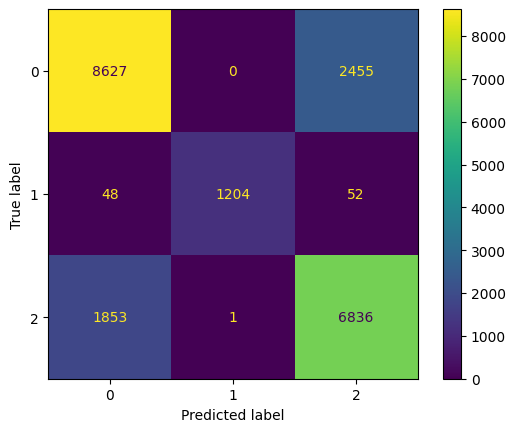

In [15]:
# Entrenar Clasificador
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train_norm, Y_train)

# Predecir test
prediction = classifier.predict(X_test_norm)

# matriz de confusión
cm = confusion_matrix(Y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()


In [16]:
print(f"Accuracy {np.count_nonzero(Y_test == prediction)/ len(Y_test)}")

Accuracy 0.7908047067754792


## Predicción de Cualquier Audio

In [18]:
def predict_file(fpath):
    signal, sampling_rate = librosa.load(fpath, sr=None)
    feats, _ = extraer_coeffs(signal, sampling_rate, '')

    to_predict = scaler.transform(feats)
    predicted = classifier.predict(to_predict)

    value_counts = {}
    for value in np.unique(predicted):
        value_counts[value] = np.count_nonzero(predicted == value)

    predicted_label = label2name[max(value_counts, key=value_counts.get)]
    return predicted_label


In [19]:
predict_file('audio_luis.wav')

'Luis'